The libraries are imported in the provided code for various specific reasons related to performing data analysis, sentiment analysis, machine learning modeling, web scraping, and financial data retrieval. Here’s a breakdown of why each library is imported:
1.	**Pandas (import pandas as pd):**

	Used for data manipulation and analysis, essential for handling structured data like scraped articles and stock market data.
2.	**NumPy (import numpy as np):**

 Provides support for large, multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays. It's crucial for numerical computations needed in data preprocessing and model training.
3.	**Scikit-learn (from sklearn...):**

 **model_selection:** Provides tools for model selection and evaluation, such as train_test_split for splitting data into training and test sets, and GridSearchCV for hyperparameter tuning.

 **preprocessing:** Includes StandardScaler for standardizing features, which is often necessary for many machine learning algorithms.

 **metrics:** Contains metrics like accuracy_score and classification_report for evaluating model performance.

 **ensemble**: Includes RandomForestClassifier for building ensemble models, known for their robustness and accuracy.

 **linear_model:** Provides LogisticRegression, a widely used model for binary classification tasks.

 **discriminant_analysis:** Includes LinearDiscriminantAnalysis for linear dimensionality reduction and classification.
4.	**Imbalanced-learn (from imblearn.over_sampling import SMOTE):**
	Specifically imported for handling imbalanced datasets by oversampling the minority class (in this case, potentially when predicting stock price movements).
5.	**TextBlob (from textblob import TextBlob):**

	Used for simplified text processing and sentiment analysis tasks, complementing the more sophisticated sentiment analysis provided by VADER.
6.	**Requests (import requests) and BeautifulSoup (from bs4 import BeautifulSoup):**

	Combined for web scraping (requests for HTTP requests and BeautifulSoup for HTML parsing). This is essential for extracting financial news articles from specified URLs.
7.	**Regular Expressions (import re):**

	Utilized for pattern matching and string manipulation tasks, such as cleaning and preprocessing text data extracted from articles.
8.	**Datetime (from datetime import datetime):**

	Provides classes for manipulating dates and times.
9.	**NLTK (from nltk.sentiment.vader import SentimentIntensityAnalyzer, import nltk):**

 	**SentimentIntensityAnalyzer:** Part of NLTK’s VADER (Valence Aware Dictionary and sEntiment Reasoner) module, specifically designed for sentiment analysis of social media text.

 	**nltk:** Overall used for natural language processing tasks like tokenization (punkt), stopwords removal (stopwords), and lemmatization (wordnet).
10.	**Yahoo Finance (import yfinance as yf):**

	Enables fetching historical stock market data directly from Yahoo Finance, which is crucial for merging sentiment analysis results with actual stock performance.
11.	**Technical Analysis (import ta) and Matplotlib (import matplotlib.pyplot as plt):**

	**ta:** Provides technical analysis indicators for financial data, enhancing the analysis of stock market trends.

	**matplotlib.pyplot:** Used for creating visualizations like plots and charts to visualize data trends and model results.
12.	NLTK Downloads (nltk.download(...)):

	Ensures necessary NLTK resources (vader_lexicon, punkt, stopwords, wordnet) **bold text** are available locally, required for performing tokenization, sentiment analysis, and text preprocessing tasks.



In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.over_sampling import SMOTE
from textblob import TextBlob
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import yfinance as yf
!pip install ta
import ta
import matplotlib.pyplot as plt
# Download NLTK resources
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

We preprocess the text data by convert text to **lowercase**, remove **punctuation**, and remove **stopwords**.
We also apply **lemmatization** technique to standardize text representations.

In [19]:
# Function to preprocess text
def preprocess_text(text):
    # Remove HTML tags using BeautifulSoup
    soup = BeautifulSoup(text, 'html.parser')
    cleaned_text = soup.get_text()

    # Remove non-alphanumeric characters and convert to lower case
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', cleaned_text)
    cleaned_text = cleaned_text.lower()

    # Tokenize the text into words
    words = nltk.word_tokenize(cleaned_text)

    # Remove stopwords
    stop_words = set(nltk.corpus.stopwords.words('english'))
    words = [w for w in words if w not in stop_words]

    # Initialize lemmatizer and stemmer
    lemmatizer = nltk.stem.WordNetLemmatizer()

    # Lemmatize words
    words = [lemmatizer.lemmatize(word) for word in words]

    # Return preprocessed text as a single string
    return ' '.join(words)


The data collected int this project is from the news website - '**Financial Express**'.
There were multiple pages to be read, for this url has been iteratively updated.
Three things were scrapped:
1. News headline
2. News description
3. Date published

The content is headline+description.
In few instances, where date was not mentioned explicitly(for example: 8months ago) in the page, date of previous news headline has been used(last_date).
The function preprocess_text() is called here to obtain cleaned content.

In [20]:
# Function to scrape articles
def scrape_articles(url_base, start_page, end_page, data, last_date):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }

    for i in range(start_page, end_page + 1):
        if i!= 1: url = f'{url_base}/page/{i}/'
        else : url = url_base
        request = requests.get(url, headers=headers)
        soup = BeautifulSoup(request.content, 'html.parser')
        articles = soup.find_all('article')

        for article in articles:
            title_div = article.find('div', class_="entry-title")
            if title_div and title_div.a:
                title = title_div.a.text.strip()  # Strip whitespace around the title
            else:
                title = '.'

            description_div = article.find('div', class_="hide-for-small-only post-excerpt")
            if description_div and description_div.p:
                description = description_div.p.text.strip()  # Strip whitespace around the description
            else:
                description = '.'

            content = title + " " + description

            # Preprocess content before adding to data dictionary
            cleaned_content = preprocess_text(content)

            date_div = article.find('div', class_="entry-meta")
            if date_div:
                date_time = date_div.find('time', class_="updated")
                if date_time:
                    date_string = date_time.text
                    try:
                        date = datetime.strptime(date_string, "%B %d, %Y").date()
                        last_date = date
                    except ValueError:
                        date = last_date
                else:
                    date = last_date
            else:
                date = last_date

            if date in data:
                data[date] += " " + cleaned_content
            else:
                data[date] = cleaned_content

    return data, last_date

This funtion does sentiment analysis of the cleaned form of the data scrapped from the website, which will be used further in the code.

In [21]:
# Function to perform sentiment analysis
def perform_sentiment_analysis(data):
    sia = SentimentIntensityAnalyzer()
    df_sentiment = pd.DataFrame(columns=['Date', 'Content', 'Negative', 'Neutral', 'Positive', 'Compound'])

    for date, content in data.items():
        sentiment = sia.polarity_scores(content)
        df_sentiment = pd.concat([df_sentiment, pd.DataFrame([{
            'Date': date,
            'Content': content,
            'Negative': sentiment['neg'],
            'Neutral': sentiment['neu'],
            'Positive': sentiment['pos'],
            'Compound': sentiment['compound']
        }])], ignore_index=True)

    return df_sentiment

This funtion helps to collect stock price data during a period.

In [22]:
# Function to fetch historical stock data
def fetch_stock_data(symbol, start_date, end_date):
    stock_data = yf.download(symbol, start=start_date, end=end_date)
    stock_data.reset_index(inplace=True)
    stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date
    return stock_data


The function takes two main sources of data: sentiment analysis from financial news articles and historical stock market data. It does the following:

**Combining Data:** It puts together sentiment analysis results with corresponding stock data based on the date when each piece of news was published.

**Handling Missing Values:** Sometimes, stock data might be missing for certain days. The function fills in these gaps by using the last known value, ensuring we have continuous data for analysis.

**Calculating Sentiment:** It calculates how subjective and positive/negative each news article is using a tool called TextBlob, which helps measure sentiment in text.

**Adding New Insights:** It creates additional insights from the stock data, such as daily percentage changes in stock prices, moving averages to spot trends over time, and volatility measures.

**Technical Indicators:** It computes technical indicators like **RSI** (Relative Strength Index) and **MACD** (Moving Average Convergence Divergence), which help predict market trends.

**Labeling Data:** Based on whether the stock price went up or down the next day, it assigns labels to each day's data. This is crucial for training machine learning models to predict future stock movements.

**Sorting and Finalizing:** Finally, it sorts all the data by date and removes any incomplete or missing data points so that we have a clean dataset ready for analysis and modeling.

In [23]:
# Function to merge data
def merge_data(df_sentiment, stock_data):
    # Merge sentiment analysis data with stock data
    merged_data = pd.merge(df_sentiment, stock_data[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']], on='Date', how='left')

    # Forward fill missing values
    merged_data.fillna(method='ffill', inplace=True)

    # Calculate subjectivity and polarity
    merged_data['Subjectivity'] = merged_data['Content'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
    merged_data['Polarity'] = merged_data['Content'].apply(lambda x: TextBlob(x).sentiment.polarity)

    # Add new features
    merged_data['Pct_Change_Open'] = merged_data['Open'].pct_change()
    merged_data['Pct_Change_High'] = merged_data['High'].pct_change()
    merged_data['Pct_Change_Low'] = merged_data['Low'].pct_change()
    merged_data['Pct_Change_Close'] = merged_data['Close'].pct_change()
    merged_data['5D_MA'] = merged_data['Close'].rolling(window=5).mean()
    merged_data['10D_MA'] = merged_data['Close'].rolling(window=10).mean()
    merged_data['Volatility'] = merged_data['Close'].rolling(window=10).std()
    merged_data['RSI'] = ta.momentum.RSIIndicator(merged_data['Close']).rsi()
    merged_data['MACD'] = ta.trend.MACD(merged_data['Close']).macd_diff()

    # Drop NaN values created by the new features
    merged_data.dropna(inplace=True)

    # Create labels: 1 if the next day's close price is higher, else 0
    merged_data['Label'] = (merged_data['Close'].shift(-1) > merged_data['Close']).astype(int)

    # Sort by Date in ascending order
    merged_data.sort_values(by='Date', ascending=True, inplace=True)

    return merged_data

This function evaluates a trading strategy based on predicted labels from machine learning models:
1.	**Initialization:**
    1.	It starts with an initial portfolio value of $100,000 and assumes starting with 50 shares of the stock.
    2.	position is set to None initially, and trades is an empty list to store details of each trade.
2.	**Strategy Parameters:**
    1.	stop_loss_pct is set to 3%, indicating the threshold where the strategy will sell to minimize losses.
    2.	take_profit_pct is set to 5%, indicating the threshold where the strategy will sell to lock in gains.
3.	**Executing Trades:**
    1.	It iterates through each prediction (y_pred) and corresponding stock data (stock_data).
    2.	If the prediction is 0 (indicating a buy signal) and position is not already 'Buy', it buys as many shares as possible with the available portfolio value (portfolio_value).
    3.	If the prediction is 1 (indicating a sell signal) and position is 'Buy', it sells all owned shares and executes stop-loss or take-profit strategies if conditions are met.
4.	**Calculating Returns:**
    
    It computes the final portfolio value after all trades and calculates the percentage returns compared to the initial portfolio value.
5.	**Performance Metrics:**
    
    It calculates additional metrics such as the Sharpe ratio, maximum drawdown, number of trades executed (num_trades), and win ratio based on successful buy trades.
6.	**Output**:
    1.	Prints performance metrics like final portfolio value, returns, Sharpe ratio, maximum drawdown, number of trades, and win ratio.
    2.	Displays a plot showing buy and sell points on the stock price chart, visualizing where trades were executed according to the strategy.



In [24]:

def evaluate_strategy(X_test, y_pred, stock_data):
    # Initialize variables
    portfolio_value = 100000  # Initial portfolio value in dollars
    shares = 50
    position = None
    trades = []

    # Parameters for trading strategy
    stop_loss_pct = 0.03  # Stop loss percentage (3%)
    take_profit_pct = 0.05  # Take profit percentage (5%)

    # Iterate over each prediction
    for idx, pred in enumerate(y_pred):
        if pred == 1 and position != 'Buy':  # Buy signal
            position = 'Buy'
            shares = portfolio_value // stock_data.iloc[idx]['Close']  # Buy as many shares as possible
            trade_value = shares * stock_data.iloc[idx]['Close']
            portfolio_value -= trade_value
            trades.append((stock_data.iloc[idx]['Date'], stock_data.iloc[idx]['Close'], 'Buy', shares))
        elif pred == 0 and position == 'Buy':  # Sell signal
            position = 'Sell'
            trade_value = shares * stock_data.iloc[idx]['Close']
            portfolio_value += trade_value
            trades.append((stock_data.iloc[idx]['Date'], stock_data.iloc[idx]['Close'], 'Sell', shares))

            # Implement stop loss and take profit
            if stock_data.iloc[idx]['Close'] < stock_data.iloc[idx-1]['Close'] * (1 - stop_loss_pct):
                # Execute stop loss
                portfolio_value += shares * stock_data.iloc[idx]['Close']
                trades.append((stock_data.iloc[idx]['Date'], stock_data.iloc[idx]['Close'], 'Stop Loss', shares))
            elif stock_data.iloc[idx]['Close'] > stock_data.iloc[idx-1]['Close'] * (1 + take_profit_pct):
                # Execute take profit
                portfolio_value += shares * stock_data.iloc[idx]['Close']
                trades.append((stock_data.iloc[idx]['Date'], stock_data.iloc[idx]['Close'], 'Take Profit', shares))

            shares = 0  # Reset shares after selling

    # Calculate returns
    final_portfolio_value = portfolio_value + shares * stock_data.iloc[-1]['Close']
    returns = (final_portfolio_value - 100000) / 100000 * 100

    # Calculate metrics
    daily_returns = stock_data['Close'].pct_change()
    sharpe = np.sqrt(252) * (np.mean(daily_returns) / np.std(daily_returns))
    max_drawdown = np.min(np.cumsum(np.log(1 + daily_returns)))
    num_trades = len(trades)
    win_trades = sum(1 for trade in trades if trade[2] == 'Buy')
    win_ratio = win_trades / num_trades if num_trades > 0 else 0

    # Print performance metrics
    print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")
    print(f"Returns: {returns:.2f}%")
    print(f"Sharpe Ratio: {sharpe:.2f}")
    print(f"Maximum Drawdown: {max_drawdown:.2f}")
    print(f"Number of Trades Executed: {num_trades}")
    print(f"Win Ratio: {win_ratio:.2f}")

    # Print trades executed
    print("\nTrades Executed:")
    for trade in trades:
        print(trade)

    # Plot buy and sell points on stock price chart
    plt.figure(figsize=(14, 7))
    plt.plot(stock_data['Date'], stock_data['Close'], label='Stock Price')
    plt.scatter([trade[0] for trade in trades if trade[2] == 'Buy'], [trade[1] for trade in trades if trade[2] == 'Buy'], marker='^', color='g', label='Buy Signal')
    plt.scatter([trade[0] for trade in trades if trade[2] == 'Sell'], [trade[1] for trade in trades if trade[2] == 'Sell'], marker='v', color='r', label='Sell Signal')
    plt.title('Buy and Sell Points based on Trading Strategy')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    return final_portfolio_value, returns, sharpe, max_drawdown, num_trades, win_ratio


This function automates the process of training machine learning models to predict stock price movements based on sentiment analysis of financial news articles and historical stock data. Here's what it does step-by-step:
1.	**Scraping and Sentiment Analysis:**
    
    It scrapes financial news articles from a specified range of pages on a website (url_base) and performs sentiment analysis on the content using the TextBlob library.
2.	**Fetching Stock Data**:
    
    It fetches historical stock data (Open, High, Low, Close, Adj Close, Volume) for a given ticker symbol (ticker_symbol) and date range (start_date to end_date) using Yahoo Finance (yfinance library).
3.	**Data Integration:**
    
    Merges the sentiment analysis results with the fetched stock data, ensuring each day's sentiment and market data are aligned.
4.	**Data Preparation:**
    
    Splits the merged data into training and testing sets, standardizes the features, and handles data imbalance using Synthetic Minority Over-sampling Technique (SMOTE).
5.	**Model Selection and Training:**
     1.	Defines two types of models (Logistic Regression and Linear Discriminant Analysis), sets up parameters for each model using Grid Search Cross-Validation (GridSearchCV), and trains them on the training data.
     2.	Evaluates each model's accuracy and performance using metrics like accuracy score and classification report.
6.	**Ensemble Modeling:**
     1.	Combines the best performing individual models into an ensemble using a VotingClassifier with a hard voting strategy.
     2.	Trains the ensemble model on the training data and evaluates its accuracy and performance.
7.	**Trading Strategy Evaluation:**
     1.	Uses the best ensemble model to predict stock price movements on the test data (X_test) and evaluates a trading strategy based on these predictions.
     2.	Calculates metrics such as final portfolio value, returns, Sharpe ratio, maximum drawdown, number of trades executed, and win ratio to assess the strategy's effectiveness.


In [25]:
# Function to train models
def train_models(company_name, ticker_symbol, url_base, start_page, end_page, start_date, end_date):
    print(f"Processing {company_name}...")

    Last_date = '2024-06-19'
    data = {}
    # Scraping financial news articles and performing sentiment analysis
    data, last_date = scrape_articles(url_base, start_page, end_page, data, Last_date)
    df_sentiment = perform_sentiment_analysis(data)

    # Fetching historical stock data
    stock_data = fetch_stock_data(ticker_symbol, start_date, end_date)

    # Merging sentiment analysis data with stock data
    merged_data = merge_data(df_sentiment, stock_data)

    # Calculate split index for 80% training data
    split_index = int(len(merged_data) * 0.8)

    # Split data into training and testing sets based on index
    train_data = merged_data.iloc[:split_index]
    test_data = merged_data.iloc[split_index:]

    # Define feature columns
    features = ['Negative', 'Neutral', 'Positive', 'Compound', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Subjectivity', 'Polarity',
                'Pct_Change_Open', 'Pct_Change_High', 'Pct_Change_Low', 'Pct_Change_Close', '5D_MA', '10D_MA', 'Volatility']

    # Split data into X and y
    X_train = train_data[features]
    y_train = train_data['Label']
    X_test = test_data[features]
    y_test = test_data['Label']

    # Handle imbalanced data using SMOTE
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Standardize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    models = {
        'Logistic Regression': {
            'model': LogisticRegression(random_state=42),
            'params': {
                'C': [0.01, 0.1, 1, 10, 100],
                'solver': ['liblinear', 'saga'],
                'max_iter': [100, 200, 500]
            }
        },
        'Linear Discriminant Analysis': {
            'model': LinearDiscriminantAnalysis(),
            'params': {
                'solver': ['svd', 'lsqr', 'eigen'],
                'shrinkage': [None, 'auto', 0.5, 0.75, 1.0]
            }
        }
    }


    best_estimators = {}

    plt.figure(figsize=(10, 8))  # Prepare to plot ROC curves

    # Train and evaluate each model
    for model_name, model_info in models.items():
        print(f"Training {model_name}...")
        grid_search = GridSearchCV(model_info['model'], model_info['params'], cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        best_estimators[model_name] = best_model
        y_pred = best_model.predict(X_test)
        y_prob = best_model.predict_proba(X_test)[:, 1]  # Get the probabilities for the positive class

        accuracy = accuracy_score(y_test, y_pred)
        print(f"Best parameters for {model_name}: {grid_search.best_params_}")
        print(f"Accuracy for {model_name}: {accuracy}")
        print(f"Classification report for {model_name}:\n{classification_report(y_test, y_pred)}")
        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        print(f"ROC AUC for {model_name}: {roc_auc:.2f}")

        # Plot ROC curve
        plt.plot(fpr, tpr, label=f'{model_name} (area = {roc_auc:.2f})')

        print("\n" + "="*60 + "\n")

    # Ensemble Model
    print("Training Ensemble Model...")
    ensemble_model = VotingClassifier(estimators=[(name, best_estimators[name]) for name in best_estimators], voting='hard')
    ensemble_model.fit(X_train, y_train)
    y_pred_ensemble = ensemble_model.predict(X_test)

    accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
    print(f"Accuracy for Ensemble Model: {accuracy_ensemble}")
    print(f"Classification report for Ensemble Model:\n{classification_report(y_test, y_pred_ensemble)}")

    # Evaluate trading strategy based on predicted labels
    evaluate_strategy(X_test, y_pred_ensemble , test_data)

    # Print merged data with labels
    print(merged_data[['Date', 'Content', 'Negative', 'Neutral', 'Positive', 'Compound', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Label']])
    print("\n\n")

    # Finalize the ROC plot
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


Processing Google...


<ipython-input-19-ffde0ee7b4ca>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')
[*********************100%%**********************]  1 of 1 completed


Training Logistic Regression...
Best parameters for Logistic Regression: {'C': 100, 'max_iter': 100, 'solver': 'liblinear'}
Accuracy for Logistic Regression: 0.7102803738317757
Classification report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.79      0.71      0.75        65
           1       0.61      0.71      0.66        42

    accuracy                           0.71       107
   macro avg       0.70      0.71      0.70       107
weighted avg       0.72      0.71      0.71       107

ROC AUC for Logistic Regression: 0.78


Training Linear Discriminant Analysis...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py", line 615, in fit
    raise NotImplementedError("shrinkage not supported with 'svd' solver.")
NotImplementedError: shrinkage not supported with 'svd' solver.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
/usr/local/lib/

Best parameters for Linear Discriminant Analysis: {'shrinkage': None, 'solver': 'lsqr'}
Accuracy for Linear Discriminant Analysis: 0.7009345794392523
Classification report for Linear Discriminant Analysis:
              precision    recall  f1-score   support

           0       0.78      0.71      0.74        65
           1       0.60      0.69      0.64        42

    accuracy                           0.70       107
   macro avg       0.69      0.70      0.69       107
weighted avg       0.71      0.70      0.70       107

ROC AUC for Linear Discriminant Analysis: 0.78


Training Ensemble Model...
Accuracy for Ensemble Model: 0.719626168224299
Classification report for Ensemble Model:
              precision    recall  f1-score   support

           0       0.79      0.74      0.76        65
           1       0.63      0.69      0.66        42

    accuracy                           0.72       107
   macro avg       0.71      0.71      0.71       107
weighted avg       0.73      0

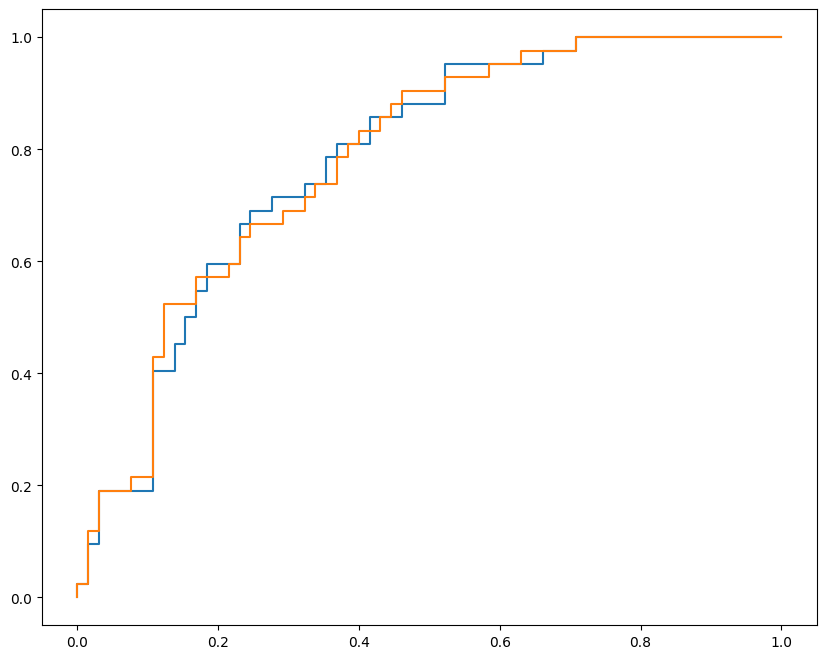

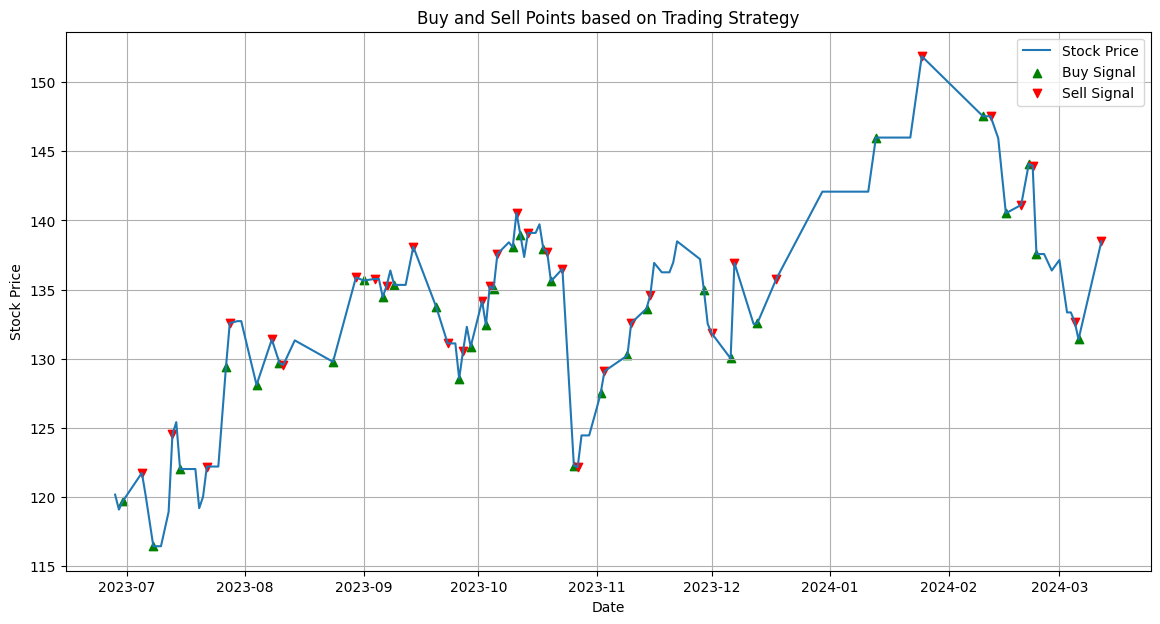

           Date                                            Content  Negative  \
565  2014-11-03  google project ara piece together android pilo...     0.000   
564  2014-11-04  asian mobile apps challenge tech giant like ap...     0.000   
563  2014-11-06  review adapting new google email chore inbox k...     0.022   
562  2014-11-07  defending privacy facebook caught increasing p...     0.145   
560  2014-11-09  manual hijack account lead severe financial lo...     0.175   
..          ...                                                ...       ...   
38   2024-03-03  indian apps including naukri 99acres restored ...     0.075   
37   2024-03-04  union minister meet google app developer resol...     0.246   
35   2024-03-05  google roll change user apps developer eu tech...     0.135   
36   2024-03-06  google blink search giant reinstate delisted i...     0.000   
34   2024-03-12  google tie eci prevent spread false informatio...     0.000   

     Neutral  Positive  Compound       

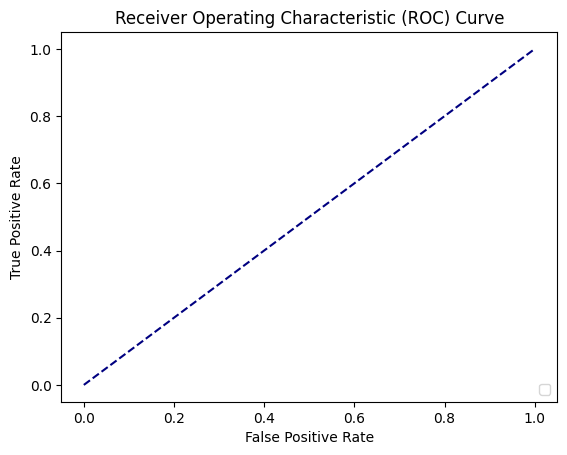

In [26]:
# Process Google
train_models(company_name='Google', ticker_symbol='GOOGL', url_base='https://www.financialexpress.com/about/google/news/', start_page=1, end_page=74,
             start_date='2014-10-29', end_date='2024-06-19')

Processing Amazon...


<ipython-input-19-ffde0ee7b4ca>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')
[*********************100%%**********************]  1 of 1 completed


Training Logistic Regression...
Best parameters for Logistic Regression: {'C': 100, 'max_iter': 100, 'solver': 'liblinear'}
Accuracy for Logistic Regression: 0.6615384615384615
Classification report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.68      0.75      0.71        36
           1       0.64      0.55      0.59        29

    accuracy                           0.66        65
   macro avg       0.66      0.65      0.65        65
weighted avg       0.66      0.66      0.66        65

ROC AUC for Logistic Regression: 0.70


Training Linear Discriminant Analysis...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
23 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py", line 631, in fit
    self._solve_eigen(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py", line 463, in _solve_eigen
    evals, evecs = linalg.eigh(Sb, Sw)
  File "/usr/local/lib/python3.10/dist-package

Best parameters for Linear Discriminant Analysis: {'shrinkage': None, 'solver': 'svd'}
Accuracy for Linear Discriminant Analysis: 0.6307692307692307
Classification report for Linear Discriminant Analysis:
              precision    recall  f1-score   support

           0       0.64      0.75      0.69        36
           1       0.61      0.48      0.54        29

    accuracy                           0.63        65
   macro avg       0.63      0.62      0.62        65
weighted avg       0.63      0.63      0.62        65

ROC AUC for Linear Discriminant Analysis: 0.70


Training Ensemble Model...
Accuracy for Ensemble Model: 0.6461538461538462
Classification report for Ensemble Model:
              precision    recall  f1-score   support

           0       0.65      0.78      0.71        36
           1       0.64      0.48      0.55        29

    accuracy                           0.65        65
   macro avg       0.64      0.63      0.63        65
weighted avg       0.64      0

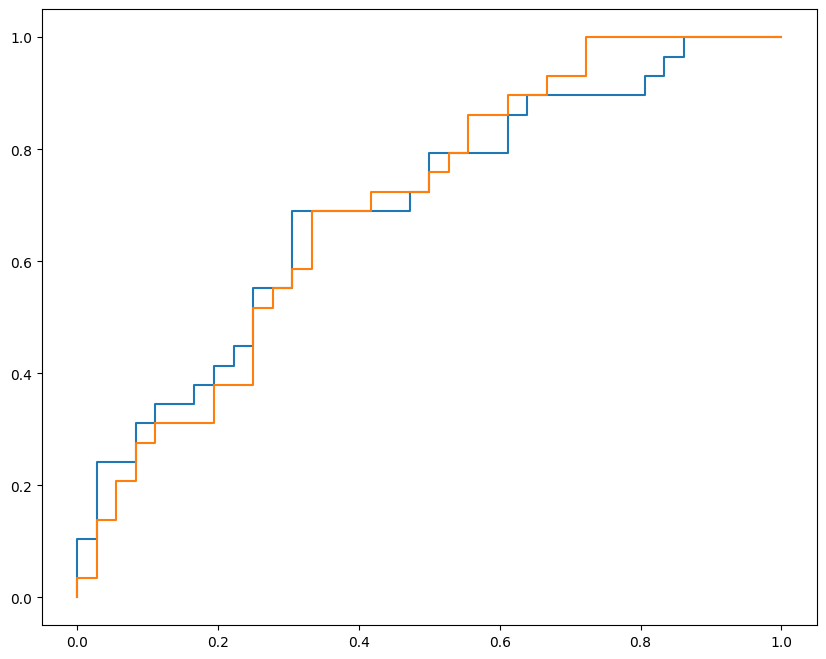

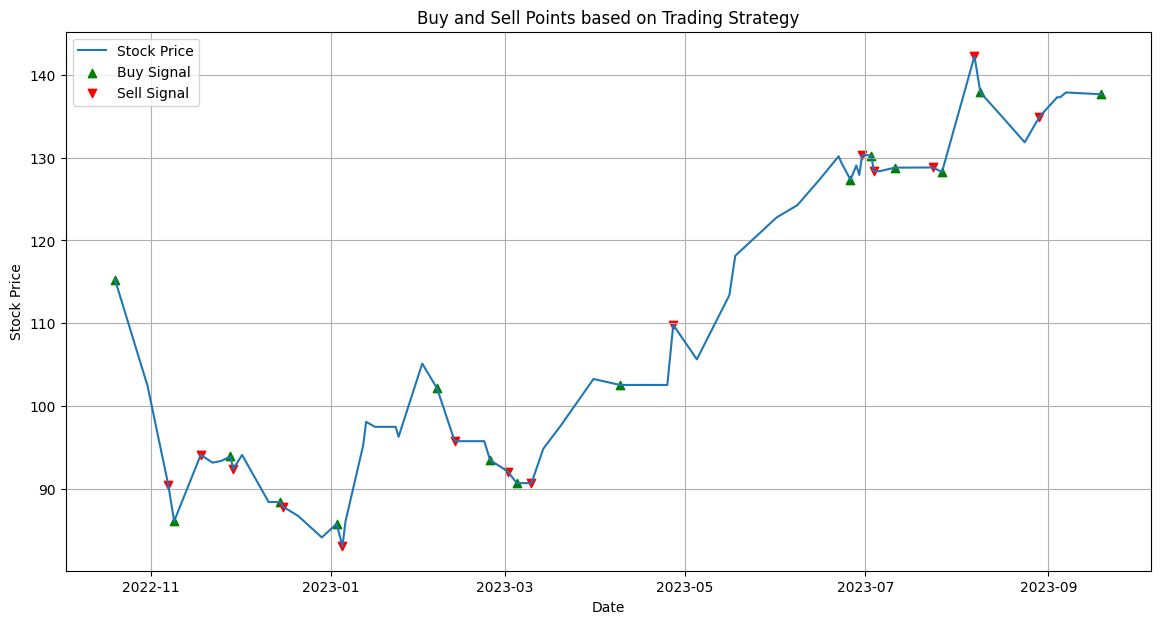

           Date                                            Content  Negative  \
355  2014-10-29  indian online retail market cross r 88000 cr 2...     0.000   
354  2014-11-04  gate crasher ambush marketing get new spin soc...     0.078   
353  2014-11-07  snake eat man offer set internet stir twitter ...     0.000   
352  2014-11-27  vat issue jds accuses congress favouring amazo...     0.048   
351  2014-12-03  gain upper hand amazon disrupts sometime last ...     0.056   
..          ...                                                ...       ...   
38   2023-08-29  amazon bos issue warning staff opposing back o...     0.144   
37   2023-09-04  amazon make initial investment 3 million natur...     0.000   
36   2023-09-05  amazon india 6000 ev fleet speaking company fu...     0.000   
35   2023-09-07  amazon smart home day sale announced 75 discou...     0.000   
34   2023-09-19  microsoft say product chief panay leave report...     0.070   

     Neutral  Positive  Compound       

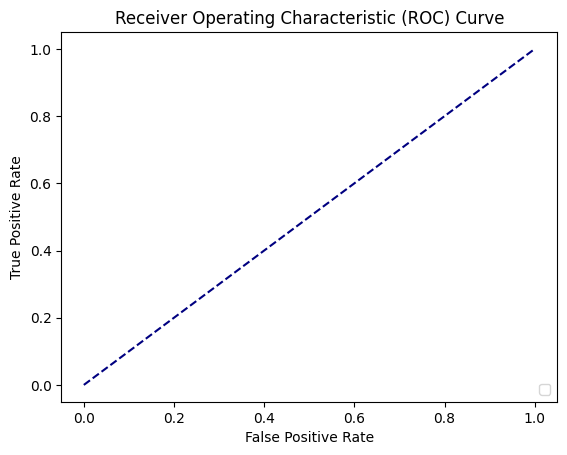

In [27]:
# Process Amazon
train_models(company_name='Amazon', ticker_symbol='AMZN', url_base='https://www.financialexpress.com/about/amazon/news/', start_page=1, end_page=45,
             start_date='2014-10-29', end_date='2024-06-19')


Processing Apple...


<ipython-input-19-ffde0ee7b4ca>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')
[*********************100%%**********************]  1 of 1 completed


Training Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters for Logistic Regression: {'C': 100, 'max_iter': 200, 'solver': 'saga'}
Accuracy for Logistic Regression: 0.7833333333333333
Classification report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83        39
           1       0.68      0.71      0.70        21

    accuracy                           0.78        60
   macro avg       0.76      0.77      0.76        60
weighted avg       0.79      0.78      0.78        60

ROC AUC for Logistic Regression: 0.82


Training Linear Discriminant Analysis...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py", line 615, in fit
    raise NotImplementedError("shrinkage not supported with 'svd' solver.")
NotImplementedError: shrinkage not supported with 'svd' solver.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
/usr/local/lib/

Best parameters for Linear Discriminant Analysis: {'shrinkage': None, 'solver': 'svd'}
Accuracy for Linear Discriminant Analysis: 0.6166666666666667
Classification report for Linear Discriminant Analysis:
              precision    recall  f1-score   support

           0       0.79      0.56      0.66        39
           1       0.47      0.71      0.57        21

    accuracy                           0.62        60
   macro avg       0.63      0.64      0.61        60
weighted avg       0.67      0.62      0.62        60

ROC AUC for Linear Discriminant Analysis: 0.74


Training Ensemble Model...
Accuracy for Ensemble Model: 0.7666666666666667
Classification report for Ensemble Model:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        39
           1       0.67      0.67      0.67        21

    accuracy                           0.77        60
   macro avg       0.74      0.74      0.74        60
weighted avg       0.77      0

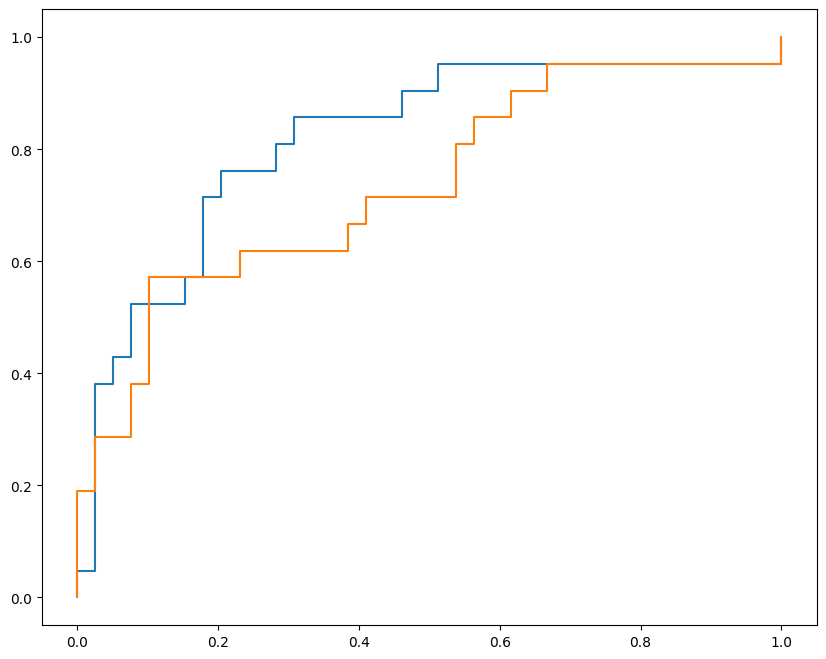

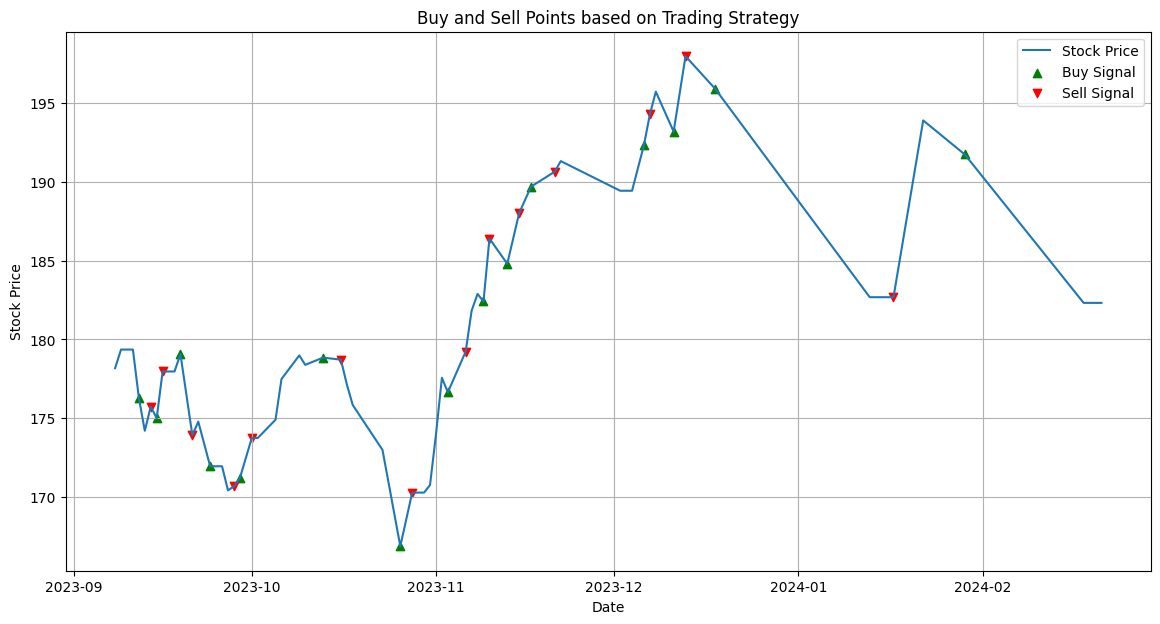

           Date                                            Content  Negative  \
331  2021-12-14  apple release tracker detect android app scan ...     0.000   
330  2021-12-21  lg working pro display xdr successor two highe...     0.000   
329  2021-12-24  apple day sale iphone 13 ipad 2021 m1 macbook ...     0.000   
328  2021-12-31  year ender facebook changing name meta apple e...     0.288   
327  2022-01-14  mac user advised update software urgently micr...     0.000   
..          ...                                                ...       ...   
38   2024-01-17  apple overtakes samsung world top smartphone b...     0.000   
37   2024-01-22  oneplus 12 gear launch january 23 5 premium af...     0.065   
36   2024-01-29  iphone user targeted china crackdown apple id ...     0.081   
35   2024-02-18  eu poised fine apple 500 million euro report e...     0.026   
34   2024-02-21  dropped iphone water put rice bag instead know...     0.000   

     Neutral  Positive  Compound       

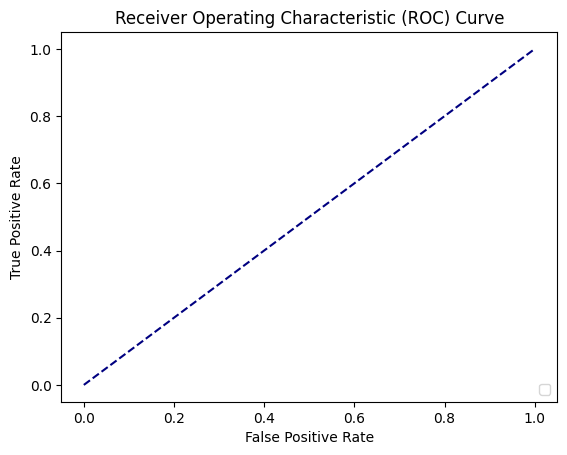

In [28]:
# Process Apple
train_models(company_name='Apple', ticker_symbol='AAPL', url_base='https://www.financialexpress.com/about/apple/news/', start_page=1, end_page=37,
             start_date='2014-10-29', end_date='2024-06-19')


Conclusion:

From model evaluation, the the precision and accuracy calculted for all the three companies are good.

The trading strategy used performs well for Google and Amazon stocks, but the return% is not good for Apple(-1.59%).

